In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import pandas as pd

In [7]:
# Grab data and split it
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
test_labels = pd.read_csv("data/test_labels.csv")
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
test_labels = test_labels.to_numpy()

print(list(train_data[0]))
print(test_data[0])
print(test_labels[0])

['0000997932d777bf', "Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27", 0, 0, 0, 0, 0, 0]
['00001cee341fdb12'
 "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"]
['00001cee341fdb12' -1 -1 -1 -1 -1 -1]


In [37]:
tr_ids = train_data[:,0]
tr_comments = np.array(train_data[:,1], dtype=str)
tr_labels = np.array(train_data[:,2:], dtype=int)

print(tr_ids[0])
print(tr_comments[0])
print(tr_labels[0])

te_ids = test_data[:,0]
te_comments = np.array(test_data[:,1], dtype=str)
te_labels = np.array(test_labels[:,1:], dtype=int)

0000997932d777bf
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
[0 0 0 0 0 0]


In [39]:
# Only use the first 20k to find the model we want
X_tr_id = tr_ids[:20000]

X_tr = tr_comments[:20000]

y_tr = tr_labels[:20000]

print(X_tr.shape)
print(y_tr.shape)

(20000,)
(20000, 6)


### Naive Bayes
Train some models and evaluate their performace, then based on that choose a Naive Bayes model to use

In [31]:
# Additional imports for naive bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier as OVRC
import time

In [63]:
# Train multiple models on the first 20k using cross validation
tic = time.time()
vals = [i/100 for i in range(1, 201)]
true_scores = []
false_scores = []
best_true_model = None
best_true_score = 0
best_false_model = None
best_false_score = 0

for aval in vals:
    model_true = make_pipeline(TfidfVectorizer(), OVRC(MultinomialNB(alpha=aval, fit_prior=True)))
    model_false = make_pipeline(TfidfVectorizer(), OVRC(MultinomialNB(alpha=aval, fit_prior=False)))
    
    # Perform 5-fold cross validation
    true_score = cross_val_score(model_true, X_tr, y_tr, cv=5).mean()
    true_scores.append(true_score)
    if(true_score > best_true_score):
        best_true_model = model_true
        best_true_score = true_score
        
    false_score = cross_val_score(model_false, X_tr, y_tr, cv=5).mean()
    false_scores.append(false_score)
    if(false_score > best_false_score):
        best_false_model = model_false
        best_false_score = false_score

    
    print(f'Evaluated value: {aval}')
    print(f'Total elapsed time: {time.time()-tic}')
        
print("Best score: " + str(best_model_score))

Evaluated value: 0.01
Total elapsed time: 21.46064591407776
Evaluated value: 0.02
Total elapsed time: 47.38828754425049
Evaluated value: 0.03
Total elapsed time: 68.44787406921387
Evaluated value: 0.04
Total elapsed time: 95.13639211654663
Evaluated value: 0.05
Total elapsed time: 116.14562582969666
Evaluated value: 0.06
Total elapsed time: 142.64201593399048
Evaluated value: 0.07
Total elapsed time: 170.32144904136658
Evaluated value: 0.08
Total elapsed time: 194.92377519607544
Evaluated value: 0.09
Total elapsed time: 215.97354698181152
Evaluated value: 0.1
Total elapsed time: 236.90600323677063
Evaluated value: 0.11
Total elapsed time: 257.8829810619354
Evaluated value: 0.12
Total elapsed time: 279.0382823944092
Evaluated value: 0.13
Total elapsed time: 300.3606815338135
Evaluated value: 0.14
Total elapsed time: 321.31070494651794
Evaluated value: 0.15
Total elapsed time: 342.5528447628021
Evaluated value: 0.16
Total elapsed time: 363.88163471221924
Evaluated value: 0.17
Total elaps

Best fit_prior=true score: 0.9040000000000001
Best fit_prior=true alpha value: 0.02

Best fit_prior=false score: 0.8989
Best fit_prior=false alpha value: 0.77


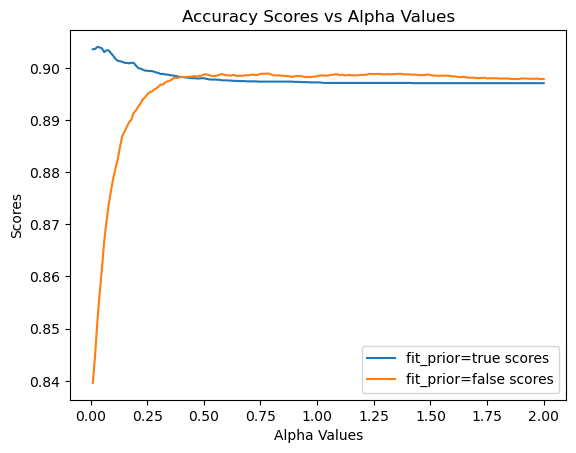

In [82]:
# visualizer for score vs alpha value
print(f'Best fit_prior=true score: {best_true_score}')
print(f'Best fit_prior=true alpha value: {0.01 * true_scores.index(best_true_score)}')
print()
print(f'Best fit_prior=false score: {best_false_score}')
print(f'Best fit_prior=false alpha value: {0.01 * false_scores.index(best_false_score)}')

plt.plot(vals, true_scores, label="fit_prior=true scores")
plt.plot(vals, false_scores, label="fit_prior=false scores")
plt.title("Accuracy Scores vs Alpha Values")
plt.xlabel("Alpha Values")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [66]:
# Train the finalized Naive Bayes model on the entire training data
tic = time.time()
best_model = make_pipeline(TfidfVectorizer(), OVRC(MultinomialNB(alpha=0.02, fit_prior=True)))
best_model.fit(tr_comments, tr_labels)
print(f'Total elapsed time: {time.time()-tic}')

Total elapsed time: 25.50170397758484


In [73]:
# Calculate error rate
from sklearn.metrics import accuracy_score

bayes_pred = best_model.predict(te_comments)

In [80]:
from sklearn.metrics import f1_score
mask = (te_labels != -1).any(axis=1)

y_pred = bayes_pred[mask]
y_eval = te_labels[mask]

bayes_acc = accuracy_score(y_eval, y_pred)
f1_micro = f1_score(y_eval, y_pred, average='micro')
f1_macro = f1_score(y_eval, y_pred, average='macro')
f1_weight = f1_score(y_eval, y_pred, average='weighted')

print("Accuracy for naive bayes: " + str(bayes_acc))
print("micro f1_score for naive bayes: " + str(f1_micro))
print("macro f1_score for naive bayes: " + str(f1_macro))
print("weighted f1_score for naive bayes: " + str(f1_weight))

Accuracy for naive bayes: 0.8949795242114477
micro f1_score for naive bayes: 0.5353268597895421
macro f1_score for naive bayes: 0.36172659478070585
weighted f1_score for naive bayes: 0.5306711530733071


### CNN

In [ ]:
import torch 
torch.set_default_dtype(torch.float64)


In [76]:
# Train multiple models on the first 20k using cross validation

tic = time.time()
somelist = []

for _ in somelist:
    # Train model
    
    # Perform 5-fold cross validation
    score = cross_val_score(model_true, X_tr, y_tr, cv=5).mean()
    
    print(f'Evaluated value: {_}')
    print(f'Total elapsed time: {time.time()-tic}')
        
print("Best score: " + str(0))

Best score: 0


In [16]:
# Train the finalized CNN model on the entire training data

In [ ]:
# Calculate error rate

### More models?